In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns
import scipy.stats as st
import time
import os
import pickle

In [2]:
# Configurations
save_stats = False
save_figs = False
load = True

## 0. Utils for Q-Learning

In [3]:
def epsilon_greedy_action(grid, Q, epsilon, num_actions = 9):
    """
    TODO
    """
    avail_indices, avail_mask = available(grid)

    if np.random.uniform(0,1) < epsilon:
        return avail_indices[np.random.randint(0, len(avail_indices))]
    else:
        q = Q[encode_state(grid)]
        q[np.logical_not(avail_mask)] = np.nan
        max_indices = np.argwhere(q == np.nanmax(q))
        return int(max_indices[np.random.randint(0, len(max_indices))])

class QPlayer:
    """
    TODO
    """
    def __init__(self, Q, player='X'):
        self.Q = Q
        self.player = player  # 'x' or 'O'

    def set_player(self, player='X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def act(self, grid, **kwargs):
        """
        TODO
        """
        return epsilon_greedy_action(grid, self.Q, 0)
    
def measure_performance(player_1, player_2, num_episodes = 500):
    """
    Measures performance of player 1 against player 2 (percentage of wins player 1)
    TODO
    """
    meas = 0
    turns = np.array(['X','O'])
    env = TictactoeEnv()
    for itr in range(num_episodes):
        env.reset()
        grid, _, _ = env.observe()
        player_1.set_player(turns[itr%2])
        player_2.set_player(turns[(itr+1)%2])
        while not env.end:
            if env.current_player == player_1.player:
                move = player_1.act(grid)
            else:
                move = player_2.act(grid)
            grid, _, _ = env.step(move, print_grid=False)
        meas += env.reward(player=player_1.player)
    return meas/num_episodes

def running_average(vec, windows_size = 250):
    idx = np.arange(0,len(vec),windows_size)
    return [np.sum(vec[i:i+windows_size])/windows_size for i in idx], idx + windows_size

def encode_state(state):
    return state.tobytes()

def available(grid):
    """
    TODO
    """
    avail_indices = []
    avail_mask = [False] * 9
    for i in range(9):
        pos = (int(i/3), i % 3)
        if grid[pos] == 0:
            avail_indices.append(i)
            avail_mask[i] = True
    return avail_indices, avail_mask

In [4]:
def q_learning_against_opt(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
               epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
    episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    if verbose:
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        player_opt = OptimalPlayer(epsilon=epsilon_opt, player=turns[(itr+1) % 2])
        env.reset()
        state, _, _ = env.observe()
        # First step of the adversarial
        if env.current_player == player_opt.player:
            move = player_opt.act(state)
            state, _, _ = env.step(move)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr+1))
        while not env.end:
            next_state, _, _ = env.step(action)     # Move according to the policy
            if not env.end:
                move = player_opt.act(next_state)   # Adversarial move
                next_state, _, _ = env.step(move)
            # Sarsa update rule
            reward = env.reward(player=my_player)
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr+1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:
                target = reward
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])
            # Preparing for the next move
            state = next_state
            action = next_action

        episode_rewards[itr] = env.reward(player=my_player)

        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

In [5]:
def q_learning_self_practice(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    # Stats of training
    episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
    episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    if verbose:
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        env.reset()
        state, _, _ = env.observe()
        # First two turns outside the loop (at least five turns are played)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr + 1))
        state_adv, _, _ = env.step(action)
        action_adv = epsilon_greedy_action(state_adv, Q, epsilon_exploration_rule(itr + 1))
        while not env.end:
            # Adversarial turn
            state_adv, _, _ = env.observe()
            reward = - env.reward(player=env.current_player)    # Reward of the player who made the last move
            next_state, _, _ = env.step(action_adv)
            # Player's turn
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr + 1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:   # action_adv is the one that makes the game end
                reward = - env.reward(player=env.current_player)    # reward of the player who made the game end, i.e. the adversary of the current player
                # Update for the adversary of the current player
                Q[encode_state(state_adv)][action_adv] += alpha * reward
                # Target for the current player
                target = - reward + gamma * Q[encode_state(next_state)][next_action]
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])

            # Preparing for the next iteration
            action = action_adv
            state = state_adv
            action_adv = next_action


        episode_rewards[itr] = env.reward(player=my_player)
        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats


    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

In [6]:
def plot_stats(stats_dict, vec_var, var_name, var_legend_name, save = False):
    fig_reward, ax_reward = plt.subplots()
    fig_performance, ax = plt.subplots(1,2, figsize=(13.4,4.8))

    for var in vec_var:
        (stats, M_opt, M_rand) = stats_dict[var]
        # Plot of the average reward during training
        running_average_rewards, x_reward = running_average(stats['rewards'])
        ax_reward.plot(x_reward, running_average_rewards, label="$"+ var_legend_name +" = "+ str(var) +"$")
        # Plot of M_opt and M_rand during training
        x_performance = np.arange(0, len(stats['rewards'])+1, len(stats['rewards']) / (len(stats['test_Mopt']) - 1))
        ax[0].plot(x_performance, stats['test_Mopt'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        ax[1].plot(x_performance, stats['test_Mrand'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        print(var_name + " =", var,": \tM_opt = ", M_opt, "\tM_rand = ", M_rand)

    ax_reward.set_ylim([-1,1])
    ax_reward.set_xlabel('Episode')
    ax_reward.set_ylabel('Reward')
    ax_reward.set_title('Average reward during training')
    ax_reward.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5, fontsize=10)


    ax[0].hlines(y=0, xmin=x[0], xmax=x[-1], color='r', linestyle='--')
    ax[0].set_ylim([-1,0.1])
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('$M_{opt}$')
    ax[0].set_title('$M_{opt}$ during training')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5, fontsize=10)

    ax[1].set_ylim([-1,1])
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('$M_{rand}$')
    ax[1].set_title('$M_{rand}$ during training')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5, fontsize=10)
    plt.show()
    if save:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.png')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.png')

## 2. Q-Learning

In [7]:
def q_learning(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False, 
                             against_opt=False, self_practice=False):
    """
    TODO
    """
    if (int(against_opt) + int(self_practice) != 1):
        raise ValueError("Please choose a training method")
    if against_opt:
        return q_learning_against_opt(env, alpha, gamma, num_episodes, epsilon_exploration,
                             epsilon_exploration_rule,  epsilon_opt, test_freq, verbose)
    else:
        return q_learning_self_practice(env, alpha, gamma, num_episodes, epsilon_exploration,
                             epsilon_exploration_rule, test_freq, verbose)

### 2.1 Learning from experts

In [8]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000
epsilon_exploration = 0.01

Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)

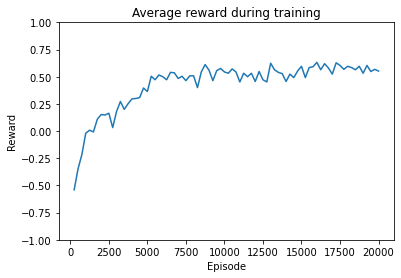


----- Optimal  player-----
M_opt =  0.0
M_rand =  0.926

----- Random  player-----
M_opt =  -0.922
M_rand =  0.016

----- Trained  player-----
M_opt =  0.0
M_rand =  0.852


In [9]:
# Plotting the average reward for every 250 games during training
running_average_rewards, x = running_average(stats['rewards'])
plt.plot(x, running_average_rewards)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)

names = ['Optimal', 'Random', 'Trained']
players = [OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.), QPlayer(Q=Q)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)

#### 2.1.1 Decreasing exploration

In [10]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [11]:
if not load:
    stats_dict_nstar = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.6875
n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.8435
n_star = 500.0 : 	M_opt =  0.0 	M_rand =  0.768
n_star = 750.0 : 	M_opt =  0.0 	M_rand =  0.854
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.789
n_star = 1279.0 : 	M_opt =  0.0 	M_rand =  0.7635
n_star = 1635.0 : 	M_opt =  -0.202 	M_rand =  0.7655
n_star = 2091.0 : 	M_opt =  -0.2905 	M_rand =  0.7275
n_star = 2674.0 : 	M_opt =  -0.1045 	M_rand =  0.773
n_star = 3420.0 : 	M_opt =  -0.109 	M_rand =  0.8235
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.7895
n_star = 5593.0 : 	M_opt =  -0.1945 	M_rand =  0.8
n_star = 7152.0 : 	M_opt =  -0.102 	M_rand =  0.706
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.7965
n_star = 11696.0 : 	M_opt =  -0.1015 	M_rand =  0.782
n_star = 14957.0 : 	M_opt =  -0.117 	M_rand =  0.7815
n_star = 19127.0 : 	M_opt =  -0.0945 	M_rand =  0.807
n_star = 24460.0 : 	M_opt =  -0.0915 	M_rand =  0.754
n_star = 31279.0 : 	M_opt =  -0.298 	M_rand =  0.6775
n_star = 40000.0 : 	M_o

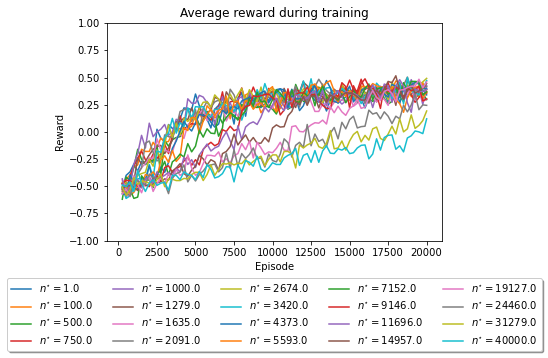

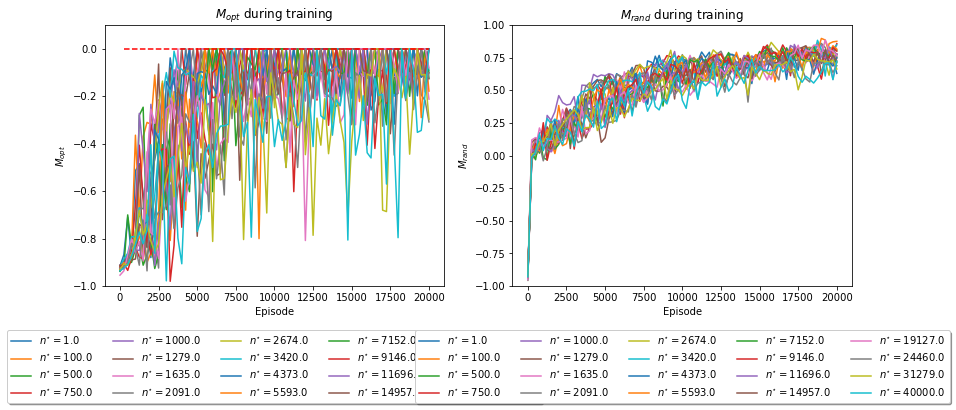

In [12]:
plot_n_star = vec_n_star
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar = pickle.load(handle)

plot_stats(stats_dict_nstar, plot_n_star, 'n_star', "n^{\star}", save=save_figs)

#### 2.1.2 Good experts and bad experts

In [13]:
n_star = 4000 # this should be picked from before not inserted manually
M = 11
vec_epsilon_opt = np.linspace(0,1,M)
print(vec_epsilon_opt)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [14]:
if not load:
    stats_dict_epsilon_opt = {}
    for epsilon_opt in vec_epsilon_opt:
        print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
        start = time.time()
        Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_epsilon_opt.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.191
epsilon_opt = 0.1 : 	M_opt =  0.0 	M_rand =  0.55
epsilon_opt = 0.2 : 	M_opt =  0.0 	M_rand =  0.5475
epsilon_opt = 0.30000000000000004 : 	M_opt =  0.0 	M_rand =  0.7255
epsilon_opt = 0.4 : 	M_opt =  -0.093 	M_rand =  0.8085
epsilon_opt = 0.5 : 	M_opt =  -0.098 	M_rand =  0.711
epsilon_opt = 0.6000000000000001 : 	M_opt =  0.0 	M_rand =  0.8245
epsilon_opt = 0.7000000000000001 : 	M_opt =  -0.098 	M_rand =  0.866
epsilon_opt = 0.8 : 	M_opt =  -0.132 	M_rand =  0.8375
epsilon_opt = 0.9 : 	M_opt =  -0.3935 	M_rand =  0.826
epsilon_opt = 1.0 : 	M_opt =  -0.264 	M_rand =  0.828


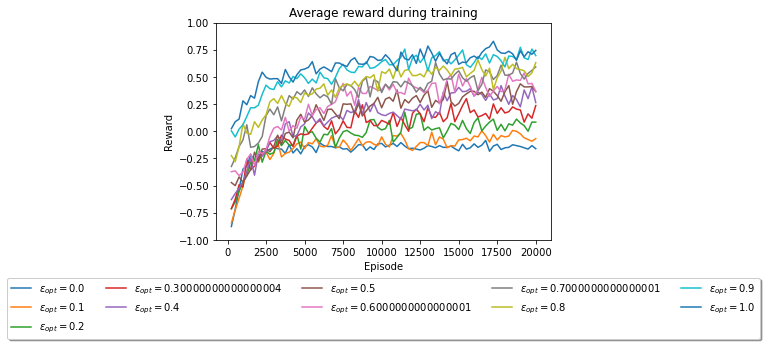

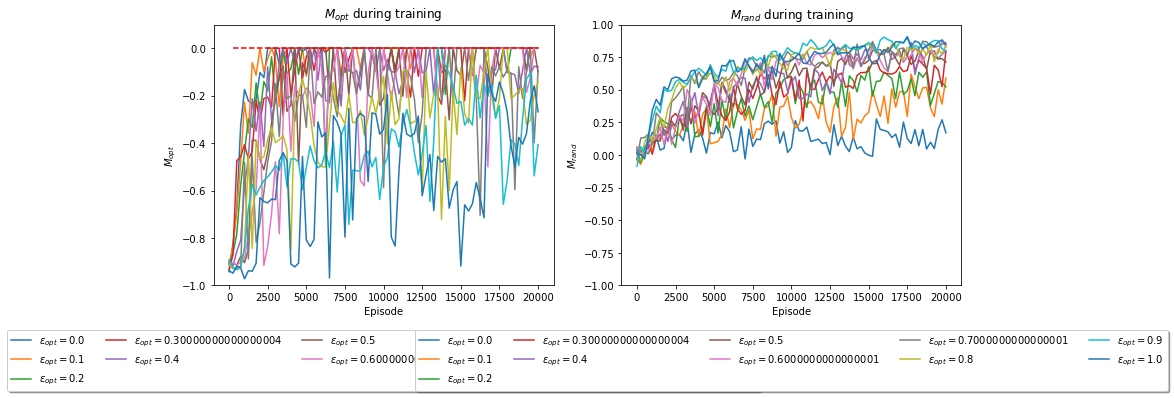

In [15]:
plot_epsilon_opt = vec_epsilon_opt
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_opt = pickle.load(handle)

plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs)

### 2.2 Learning by self-practice

#### Question 7: Fixed $\epsilon$ first

In [16]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [17]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps_self = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        Q, stats = q_learning(env, num_episodes=num_episodes,
                            epsilon_exploration=epsilon, test_freq = 250, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps_self.update({epsilon: (stats, M_opt, M_rand)})

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_self = 0.0 : 	M_opt =  -0.7505 	M_rand =  0.2285
epsilon_self = 0.0001 : 	M_opt =  -0.9285 	M_rand =  0.387
epsilon_self = 0.0005 : 	M_opt =  -0.6435 	M_rand =  0.4165
epsilon_self = 0.001 : 	M_opt =  -0.4875 	M_rand =  0.4275
epsilon_self = 0.005 : 	M_opt =  -0.191 	M_rand =  0.683
epsilon_self = 0.01 : 	M_opt =  -0.148 	M_rand =  0.8135
epsilon_self = 0.05 : 	M_opt =  -0.103 	M_rand =  0.928
epsilon_self = 0.1 : 	M_opt =  0.0 	M_rand =  0.919
epsilon_self = 0.5 : 	M_opt =  -0.3065 	M_rand =  0.726
epsilon_self = 1.0 : 	M_opt =  -0.9045 	M_rand =  0.5325


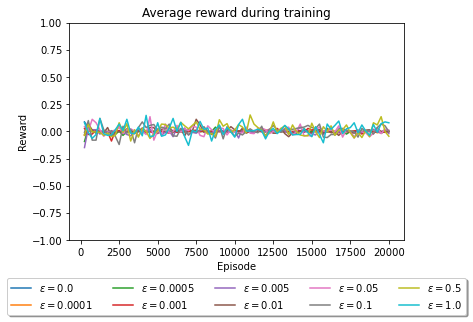

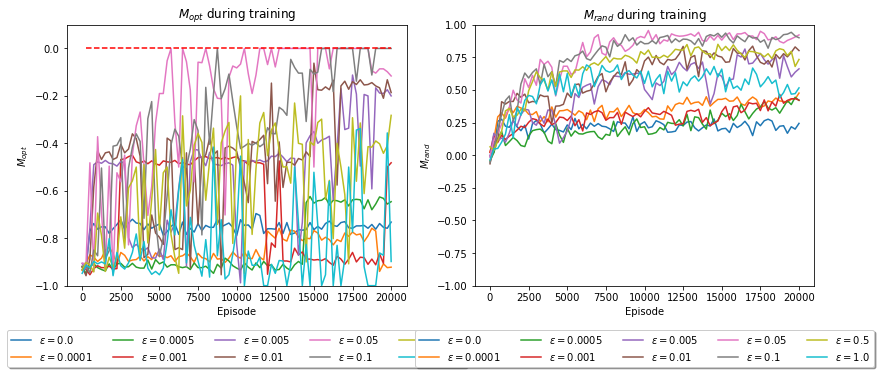

In [18]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self = pickle.load(handle)

plot_stats(stats_dict_eps_self, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs)

#### Question 8: Changing exploration rule, $\epsilon$ decay

In [19]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
epsilon_min = 0.1
epsilon_max = 0.8

In [20]:
if not load:
    stats_dict_nstar_self = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule,
                                test_freq=test_freq,  num_episodes=num_episodes, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=200)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=200)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar_self.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, "took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star_self = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star_self = 100.0 : 	M_opt =  0.0 	M_rand =  0.91
n_star_self = 500.0 : 	M_opt =  0.0 	M_rand =  0.85
n_star_self = 750.0 : 	M_opt =  0.0 	M_rand =  0.955
n_star_self = 1000.0 : 	M_opt =  0.0 	M_rand =  0.935
n_star_self = 1279.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star_self = 1635.0 : 	M_opt =  -0.12 	M_rand =  0.88
n_star_self = 2091.0 : 	M_opt =  0.0 	M_rand =  0.855
n_star_self = 2674.0 : 	M_opt =  -0.09 	M_rand =  0.92
n_star_self = 3420.0 : 	M_opt =  -0.09 	M_rand =  0.87
n_star_self = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star_self = 5593.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star_self = 7152.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star_self = 9146.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star_self = 11696.0 : 	M_opt =  -0.085 	M_rand =  0.94
n_star_self = 14957.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star_self = 19127.0 : 	M_opt =  -0.245 	M_rand =  0.885
n_star_self = 24460.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star_self = 31279.0 : 	M_opt

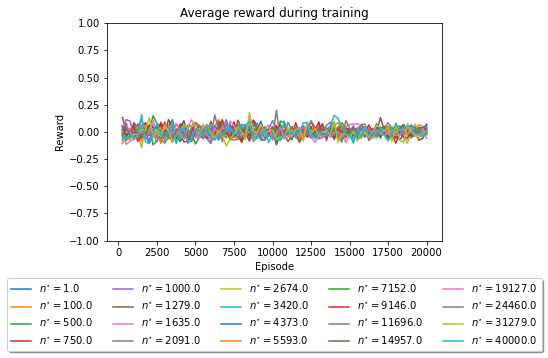

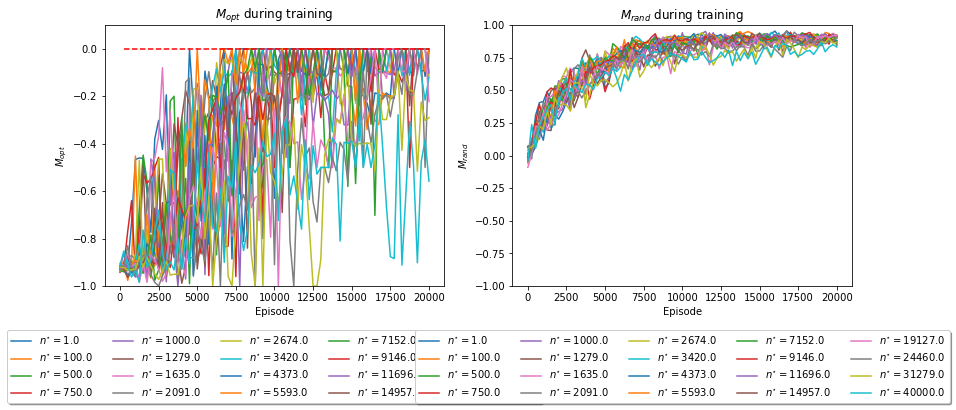

In [21]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self = pickle.load(handle)

plot_stats(stats_dict_nstar_self, vec_n_star, "n_star_self", "n^{\star}", save=save_figs)

#### Question 9: TODO look for optimal $M_{opt}$ and $M_{rand}$

In [22]:
### look for optimal values of M_opt and M_rand

#### Question 10: heat maps in 3 different states

In [23]:
def heatmaps_subplots(grids, Q):
    fig, ax = plt.subplots(1, grids.shape[0], sharex='col', figsize=(10, 5))
    plt.subplots_adjust(wspace=1.5)
    grids_ = np.reshape(grids, (grids.shape[0], 3, 3))
    for i in range(grids.shape[0]):
        print(grids[i, :])
        df = Q[encode_state(grids[i, :])][:]
        df = np.reshape(df, (3, 3))
        ax[i].table(cellText=grids_[i])
        sns.heatmap(df, annot=True, mask=(grids_[i] != 0), linewidths=.5,
                    ax=ax[i], xticklabels=False, yticklabels=False)
        ax[i].axis("off") 

[ 1  0  0 -1  0  0  0 -1  1]
[ 1 -1  1  0  0  1  0 -1 -1]
[ 0 -1  1  0  0  1  0  0 -1]


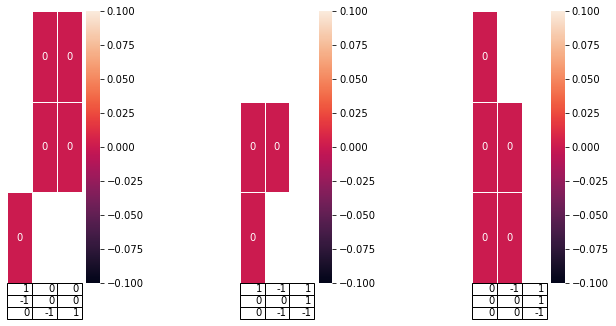

In [24]:
grids = np.array([[1, 0, 0, -1, 0, 0, 0, -1, 1], [1, -1, 1, 0, 0, 1, 0, -1, -1], [0, -1, 1, 0, 0, 1, 0, 0, -1]])
heatmaps_subplots(grids, Q)

## Deep Q-Learning